<a href="https://colab.research.google.com/github/blakebordelon/NTK_Learning_Curves/blob/master/perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade https://storage.googleapis.com/jax-releases/`nvcc -V | sed -En "s/.* release ([0-9]*)\.([0-9]*),.*/cuda\1\2/p"`/jaxlib-0.1.55-`python3 -V | sed -En "s/Python ([0-9]*)\.([0-9]*).*/cp\1\2/p"`-none-manylinux2010_x86_64.whl jax

import numpy as np
import math
import matplotlib.pyplot as plt
import jax.numpy as jnp

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

     |████████████████████████████████| 144.8MB 77kB/s 
     |████████████████████████████████| 460kB 2.8MB/s 
  Created wheel for jax: filename=jax-0.2.0-cp36-none-any.whl size=522279 sha256=5f02dd5bbfe998d5acb4a71edf3c5e6cb915abb821244ad5c2c53dc09c54716b
  Stored in directory: /root/.cache/pip/wheels/99/f1/91/e9c21aca3142a6d2e5e760162fd65a1430438b7630a0b75591
Successfully built jax
  Found existing installation: jaxlib 0.1.52
    Uninstalling jaxlib-0.1.52:
      Successfully uninstalled jaxlib-0.1.52
  Found existing installation: jax 0.1.75
    Uninstalling jax-0.1.75:
      Successfully uninstalled jax-0.1.75
Mounted at /content/gdrive


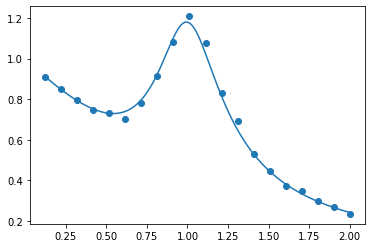

In [ ]:
def perceptron_expt(pvals, N, lamb = 0.25, sigma = 0, num_repeats=5):
  errs = np.zeros((len(pvals), num_repeats))
  for i,p in enumerate(pvals):
    key = random.PRNGKey(1)
    for j in range(num_repeats):
      key, teach, train, test, noise = random.split(key, 5)
      w_teach = 1/np.sqrt(N) * random.normal(teach, (N,))
      X_tr = random.normal(train, (p,N))
      X_te = random.normal(test, (5000, N))
      y = X_tr @ w_teach + sigma * random.normal(noise, (p,)) 
      y_true = X_te @ w_teach
      if lamb == 0:
        if p < N:
          yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T) @ y
        else:
          yhat = X_te @ jnp.linalg.inv(X_tr.T @ X_tr) @ X_tr.T @ y
      else:
        yhat = X_te @ X_tr.T @ jnp.linalg.inv(X_tr @ X_tr.T + N*lamb*jnp.eye(p)) @ y

      errs[i,j] = np.mean((yhat - y_true)**2)
  return errs
  

def theory(alpha, sigma, lamb):
  z = 0.5 * ( 1+lamb - alpha + np.sqrt( (1+lamb - alpha)**2 + 4*lamb*alpha ) )
  return (z**2 + sigma**2 * alpha) / ( (alpha+z)**2 - alpha )


N = 800
num_repeats = 12
sigma = 0.5
lamb = 0.01
pvals = np.linspace(100,2*N,num = 20).astype('int')
errs = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=num_repeats)
ptheory = np.linspace(100, 2*N, num = 1000)
theory_errs = theory(ptheory/N, sigma, lamb)
plt.scatter(pvals/N, np.mean(errs,axis =1))
plt.plot(ptheory/N, theory_errs)
plt.show()

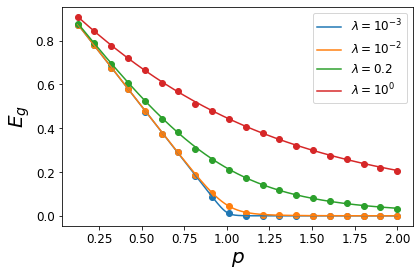

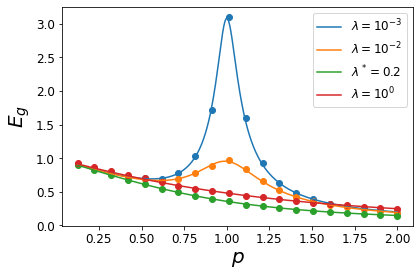

In [ ]:
## TO DOs (Blake) 
##1. interpolation expt 2. vary lambda 3. vary sigma 4. make phase diagram
## 

sigma = 0
lamb_vals = [1e-3,1e-2,0.2,1]
ptheory = np.linspace(100, 2*N, num = 1000)
pvals = np.linspace(100,2*N,num = 20).astype('int')

plt.rcParams.update({'font.size': 12})


all_expt = []
all_theory = []
for i, lamb in enumerate(lamb_vals):
  errs = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=num_repeats).mean(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  all_expt += [errs]
  all_theory += [theory_errs]


for i, lamb in enumerate(lamb_vals):
  plt.scatter(pvals/N, all_expt[i])
  if lamb == 0.2:
    plt.plot(ptheory/N, all_theory[i] , label = r'$\lambda = %0.1f$' % lamb )
  else:
    plt.plot(ptheory/N, all_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)) )
plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'reg_no_noise_percptr.pdf')
plt.show()


# make noise nonzero
sigma = np.sqrt(0.2)

all_expt = []
all_theory = []
for i, lamb in enumerate(lamb_vals):
  errs = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=2*num_repeats).mean(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  all_expt += [errs]
  all_theory += [theory_errs]


for i, lamb in enumerate(lamb_vals):
  plt.scatter(pvals/N, all_expt[i])
  if lamb == 0.2:
    plt.plot(ptheory/N, all_theory[i] , label = r'$\lambda^*  = %0.1f$' % lamb)
  else:
    plt.plot(ptheory/N, all_theory[i] , label = r'$\lambda = 10^{%d}$' % int(np.log10(lamb)) )

plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.tight_layout()
plt.savefig(root_dir + 'reg_with_noise_percptr.pdf')
plt.show()



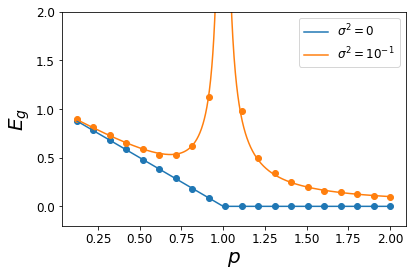

In [ ]:
sigmavals = [0,np.sqrt(1e-1)]
lamb = 0
all_expt = []
all_theory = []
for i, sigma in enumerate(sigmavals):
  errs = perceptron_expt(pvals, N, sigma=sigma, lamb = lamb, num_repeats=2*num_repeats).mean(axis=1)
  theory_errs = theory(ptheory/N, sigma, lamb)
  all_expt += [errs]
  all_theory += [theory_errs]

for i, sigma in enumerate(sigmavals):
  plt.scatter(pvals/N, all_expt[i])

plt.plot(ptheory/N, all_theory[0] , label = r'$\sigma^2 = 0$')
plt.plot(ptheory/N, all_theory[1] , label = r'$\sigma^2 = 10^{-1}$')

plt.legend()
plt.xlabel(r'$p$', fontsize = 20)
plt.ylabel(r'$E_g$', fontsize = 20)
plt.ylim([-0.2,2])
plt.tight_layout()
plt.savefig(root_dir + 'noise_no_reg_percptr.pdf')
plt.show()


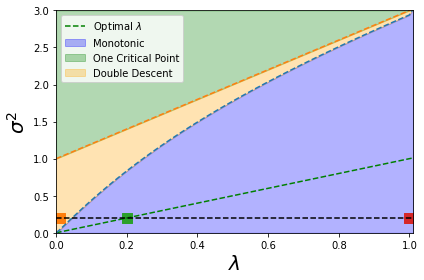

In [ ]:
res = 100
lamb_grid = np.linspace(0.0,1.01, res)
sigma2_grid = np.linspace(0,2, res)

def func_boundary(lamb):
  result = []
  for i, l in enumerate(lamb):
    if l <= 1:  
      angle = math.pi/3 + 1/3*np.arctan2( 8*np.sqrt(l)/(9*l*(3*l+2)+1), 1 )
      comp = 3*l*(3*l+2 -2 * np.sqrt(l+1)*np.sqrt(9*l+1) * np.cos(angle))
      result += [comp]
    else:
      result += [2*l + 1]
  return result

plt.plot(lamb_grid, lamb_grid, '--', color = 'green', label = r'Optimal $\lambda$')
plt.plot(lamb_grid, func_boundary(lamb_grid), '--', color = 'C0')
plt.plot(lamb_grid, 2*lamb_grid+1, '--', color = 'C1')
plt.fill_between(lamb_grid, np.zeros(len(lamb_grid)), func_boundary(lamb_grid), alpha = 0.3, color = 'blue', label = 'Monotonic')
plt.fill_between(lamb_grid, 2*lamb_grid+1, 3*np.ones(len(lamb_grid)), alpha = 0.3, color = 'green', label = 'One Critical Point')
plt.fill_between(lamb_grid, func_boundary(lamb_grid), 2*lamb_grid+1, alpha = 0.3, color = 'orange', label = 'Double Descent')
plt.scatter([0.001],[0.2], s=100, marker='s', color = 'C0')
plt.scatter([0.01],[0.2], s=100, marker = 's', color = 'C1')
plt.scatter([0.2],[0.2], s=100, marker = 's', color = 'C2')
plt.scatter([1],[0.2], s=100, marker = 's', color = 'C3')
plt.plot(lamb_grid, 0.2*np.ones(len(lamb_grid)) , '--', color = 'black')
plt.legend()
plt.xlabel(r'$\lambda$', fontsize =20)
plt.ylabel(r'$\sigma^2$', fontsize = 20)
plt.xlim([0, np.amax(lamb_grid)])
plt.ylim([0,3])
plt.tight_layout()
plt.savefig(root_dir + 'phase_diag_white_theory.pdf')
plt.show()

